<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Lesson20_Uplift/uplift_CT_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uplift

Банк запускает активационные кампании по кредитным картам с использованием различных каналов коммуникации. Персональные звонки клиентам - довольно затратный способ коммуникации, при этом не все клиенты позитивно реагируют на такой формат общения: кому-то будет достаточно СМС или пуш-уведомления.
Ваша задача — помочь банку оптимизировать расходы на коммуникации, научившись предсказывать разницу в эффективности голосовых звонков на основе клиентских данных. В качестве решения необходимо предоставить предсказанный моделью uplift для каждого клиента из тестовой выборки.

Данные:

Используя историю взаимодействий, сессии мобильного приложения, заявки на продукты и другие признаки, вам предстоит создать модель, которая сможет повысить эффективность кампаний за счет персонализированного выбора наиболее подходящего способа общения с каждым клиентом.

Признаки, которые содержатся в выборках:
* successful_utilization – переменная, которая показывает, воспользовался ли клиент кредитным продуктом

* retro_date – дата создания задачи на клиента

* treatment – колонка, которая показывает, имела ли место голосовая коммуникация с клиентом. 1 – с клиентом общались по голосовому каналу, 0 – с клиентом в этот момент могли общаться по голосовому каналу, но не стали

* mb – группа признаков, которая характеризует сессии в мобильном приложении клиента

* application – группа признаков, которая характеризует различные заявки клиентов на наши продукты в прошлом

* bki - группа признаков, которая характеризует походы клиентов в Бюро Кредитных Историй

* partner - группа признаков, которая характеризует различные подписки клиентов на партнерские сервисы

* graph - группа признаков, которая характеризует данные о контактных книжках наших клиентов

* feature – группа признаков, которая скрыта от описания

Метрика:
Качество решения определяется с помощью метрики Area under uplift curve (AUUQ).

Подробнее про метрику - https://habr.com/ru/companies/ru_mts/articles/538934/

In [ ]:
!wget https://storage.yandexcloud.net/uplift-bucket/uplift_train.csv
!wget https://storage.yandexcloud.net/uplift-bucket/uplift_test.csv

--2025-01-30 14:16:42--  https://storage.yandexcloud.net/uplift-bucket/uplift_train.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286885205 (274M) [text/csv]
Saving to: ‘uplift_train.csv’

uplift_train.csv    100%[===================>] 273.59M  22.4MB/s    in 12s     

2025-01-30 14:16:55 (22.1 MB/s) - ‘uplift_train.csv’ saved [286885205/286885205]

--2025-01-30 14:16:55--  https://storage.yandexcloud.net/uplift-bucket/uplift_test.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71700603 (68M) [text/csv]
Saving to: ‘uplift_test.csv’

uplift_test.csv     100%[===================>]  68.

# Решение

In [ ]:
!pip install -U scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.
bigframes 1.33.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
!pip install scikit-uplift

In [ ]:
!pip install catboost -q

In [ ]:
!pip install causalml -q

In [ ]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer

from sklift.models import ClassTransformation
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn import metrics
import matplotlib.pyplot as plt

np.random.seed(0)

import seaborn as sns

from sklift.metrics import qini_auc_score, uplift_auc_score
from sklift.viz import plot_qini_curve

In [ ]:
# load train and test data

train = pd.read_csv("uplift_train.csv")
test = pd.read_csv("uplift_test.csv")

train.head()

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,successful_utilization,treatment
0,NaN,1.0,Representatives,123.0,Первичная ДК,1,14.0,147000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-07-04,0,1
1,NaN,1.0,Offline,43.0,Airports,0,1.0,120000.0,PLT,0.0,...,1.0,0,1.0,0.0,-1.2,1.0,0,2024-06-06,0,1
2,0.0,1.0,Web,2.0,seo,0,NaN,15000.0,PLT,0.0,...,NaN,0,NaN,0.0,-1.2,1.0,0,2024-07-21,1,1
3,0.0,1.0,MB,2.0,One Click Offer,0,91.0,260000.0,PLT,0.0,...,1.0,0,NaN,1.0,-1.2,1.0,0,2024-05-23,0,1
4,0.0,1.0,Representatives,123.0,Первичная ДК,1,1.0,130000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-06-28,0,1


In [ ]:
test.head()

,application_1,cc_1,cc_2,cc_3,cc_4,feature_1,mb_1,cc_5,cc_6,feature_2,...,cc_21,application_15,feature_25,feature_26,cc_22,partner_24,application_16,retro_date,successful_utilization,treatment
0,0.0,1.0,NaN,NaN,NaN,0,6.0,NaN,NaN,0.0,...,1.0,0,0.0,0.0,-1.2,1.0,0,2024-06-18,0,1
1,0.0,1.0,NaN,NaN,NaN,0,45.0,NaN,NaN,0.0,...,0.0,0,0.0,1.0,-1.2,1.0,0,2024-05-09,0,1
2,0.0,1.0,MB,2.0,Heavy xsell,0,13.0,299000.0,PLT,0.0,...,NaN,0,NaN,0.0,-1.2,1.0,0,2024-05-30,1,1
3,0.0,1.0,Representatives,123.0,SIM,1,158.0,140000.0,PLT,0.0,...,NaN,0,1.0,0.0,-1.2,1.0,0,2024-05-27,0,1
4,0.0,1.0,Representatives,123.0,Первичная ДК,0,36.0,170000.0,PLT,0.0,...,0.0,0,1.0,0.0,-1.2,1.0,0,2024-06-08,1,1


Обрабатываем признаки

In [ ]:
feature_cols = [c for c in list(train.columns) if c != "successful_utilization" and c != "treatment"]
X_train = train[feature_cols]
X_test = test[feature_cols]

y_train = train["successful_utilization"]
treatment_train = train['treatment']

In [ ]:
categorical_features = X_train.select_dtypes(exclude='number').columns
numeric_features = X_train.select_dtypes(include='number').columns

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first')),
    ]
)

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", imp, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)

ppl = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

In [ ]:
ppl.fit(X_train)
X_train = ppl.transform(X_train)
X_test = ppl.transform(X_test)

Обучаем модель

Как работает ClassTransformation:

1. Цель метода:

ClassTransformation преобразует исходную задачу uplift-моделирования в задачу классификации. Цель состоит в том, чтобы создать модель, которая будет предсказывать вероятность целевого события с учётом проведенного воздействия (например, воздействия на целевую группу) и без него (на контрольную группу).

2. Преобразование задачи:

Этот метод изменяет целевую переменную таким образом, чтобы можно было обучать обычную модель классификации (например, логистическую регрессию или случайный лес) для предсказания uplift-эффекта:

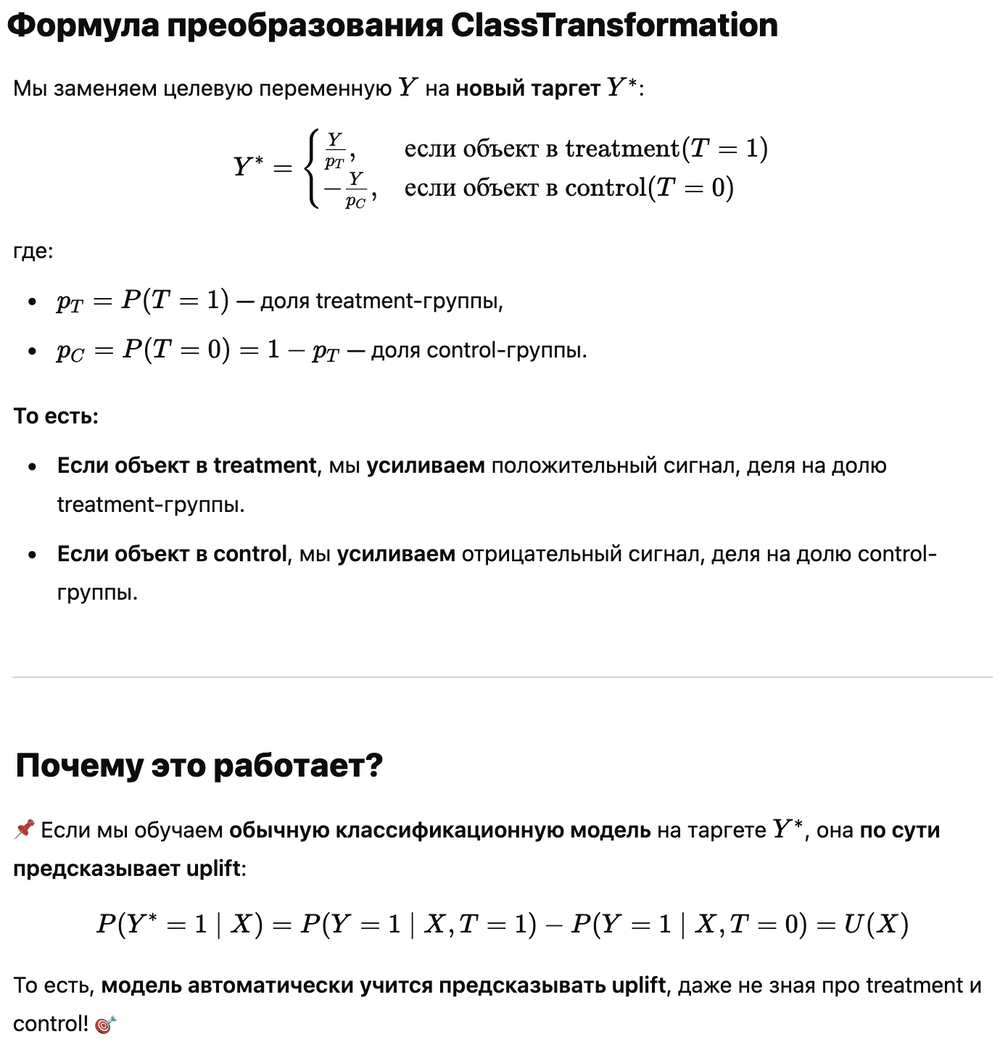

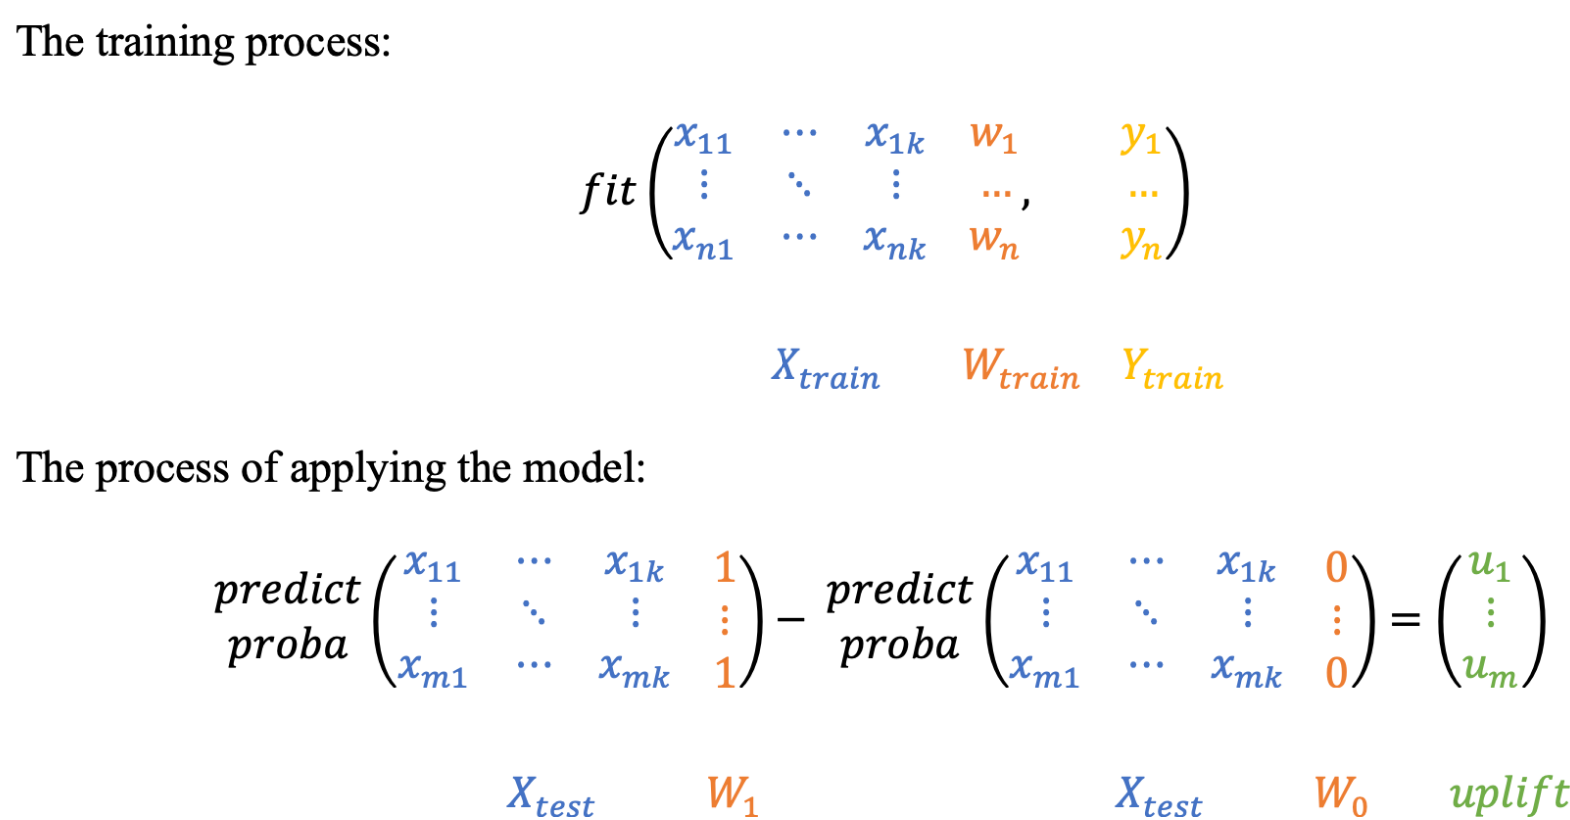

In [12]:
estimator = CatBoostClassifier(verbose=100,
                               random_state=42,
                               thread_count=1)

ct_model = ClassTransformation(estimator=estimator)

In [ ]:
ct_model.fit(
    X=X_train,
    y=y_train,
    treatment=treatment_train
)

Learning rate set to 0.117208
0:	learn: 0.6631105	total: 556ms	remaining: 9m 15s
100:	learn: 0.5344633	total: 28.1s	remaining: 4m 10s
200:	learn: 0.5263286	total: 57.2s	remaining: 3m 47s
300:	learn: 0.5205394	total: 1m 37s	remaining: 3m 47s
400:	learn: 0.5154097	total: 2m 6s	remaining: 3m 9s
500:	learn: 0.5107316	total: 2m 34s	remaining: 2m 33s


In [ ]:
uplift_ct = ct_model.predict(X_test)

### Проверим качество модели на тестовых данных

In [ ]:
y_test = test["successful_utilization"]
treatment_test = test['treatment']

In [ ]:
# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_test, uplift_ct, treatment_test)
print(f"Qini coefficient on full data: {auqc:.4f}")
auuc = uplift_auc_score(y_test, uplift_ct, treatment_test)
print(f"AUUC coefficient on full data: {auuc:.4f}")

Qini coefficient on full data: 0.0736
AUUC coefficient on full data: 0.0700


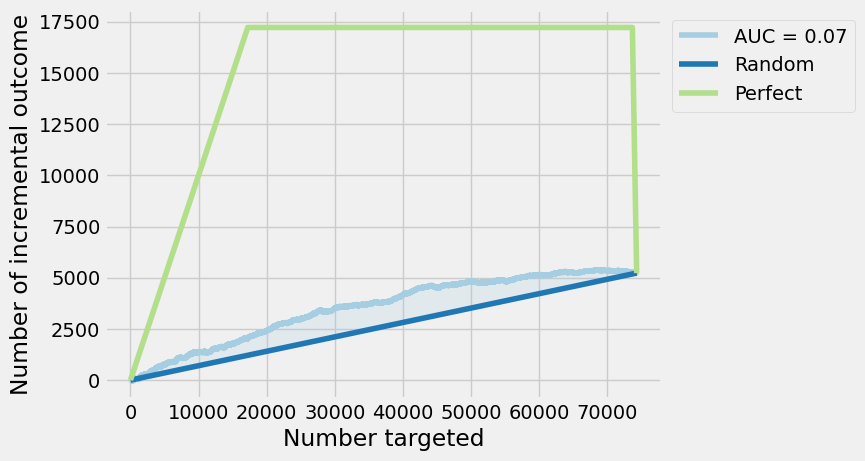

In [ ]:
# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_test, uplift_ct, treatment_test, perfect=True)

### Как можно улучшить прогноз?

* Работа с признаками

* Подбор гиперпараметров

* Metalearners. Методы основанные на использовании моделей машинного обучения в качестве базовых

* Преобразование классов

* Uplift-решающие деревья и методы, основанные на их ансамблях